## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install dependencies
# !pip install fastai jupyter timm torchtnt

# # Install PyTorch with CUDA
# pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install utility packages
# !pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF
from torchtnt.utils import get_module_summary

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import fastai computer vision functionality 
from fastai.vision.all import *

## Setting Up the Project

### Setting a Random Number Seed

In [3]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 123
set_seed(seed)

### Setting the Device and Data Type

In [4]:
device = default_device()
dtype = torch.float32
device, dtype

(device(type='cuda', index=0), torch.float32)

### Setting the Directory Paths

In [5]:
# The name for the project
project_name = f"fastai-timm-image-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)
print(project_dir)

# Define path parent directory to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset parent directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

fastai-timm-image-classifier
Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [6]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k-zip'

zip_file_name = dataset_name[:-4]

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'
print(f"HuggingFace Dataset: {hf_dataset}")

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{zip_file_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{zip_file_name}')
print(f"Dataset Path: {dataset_path}")

HuggingFace Dataset: cj-mills/hagrid-classification-512p-no-gesture-150k-zip
Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


### Downloading the Dataset

In [7]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{zip_file_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
untar_data(dataset_url, archive=archive_path.parent, data=dataset_path.parent)

# Delete the archive if specified
if archive_path.exists() and delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/hagrid-classification-512p-no-gesture-150k-zip/resolve/main/hagrid-classification-512p-no-gesture-150k.zip


### Inspecting the Class Distribution

#### Get image classes

In [8]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

0
0              call
1           dislike
2              fist
3              four
4              like
5              mute
6        no_gesture
7                ok
8               one
9              palm
10            peace
11   peace_inverted
12             rock
13             stop
14    stop_inverted
15            three
16           three2
17           two_up
18  two_up_inverted

**Get image paths**


In [9]:
# Get a list of all image file paths from the given folders
class_folder_paths = [get_img_files(folder) for folder in folders]

class_counts_dict = {class_paths[0].parent.name:len(class_paths) for class_paths in class_folder_paths}

# Flatten the list of lists into a single list
img_paths = [path for class_paths in class_folder_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

#### Visualize the class distribution

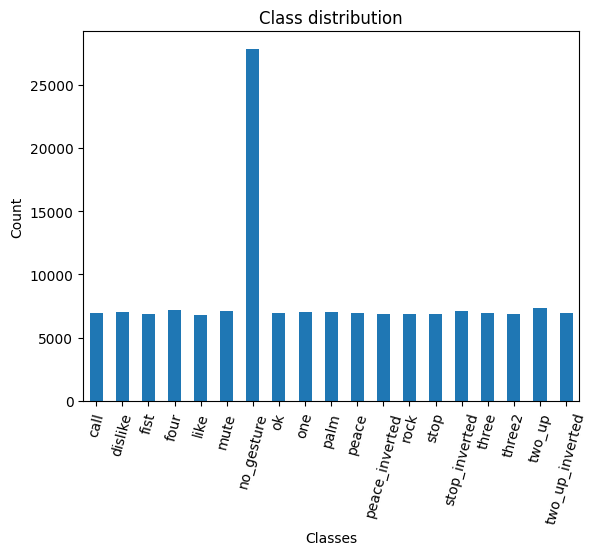

In [10]:
class_counts = pd.DataFrame.from_dict(class_counts_dict, orient='index')

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.gca().legend().set_visible(False)
plt.show()

### Visualizing Sample Images

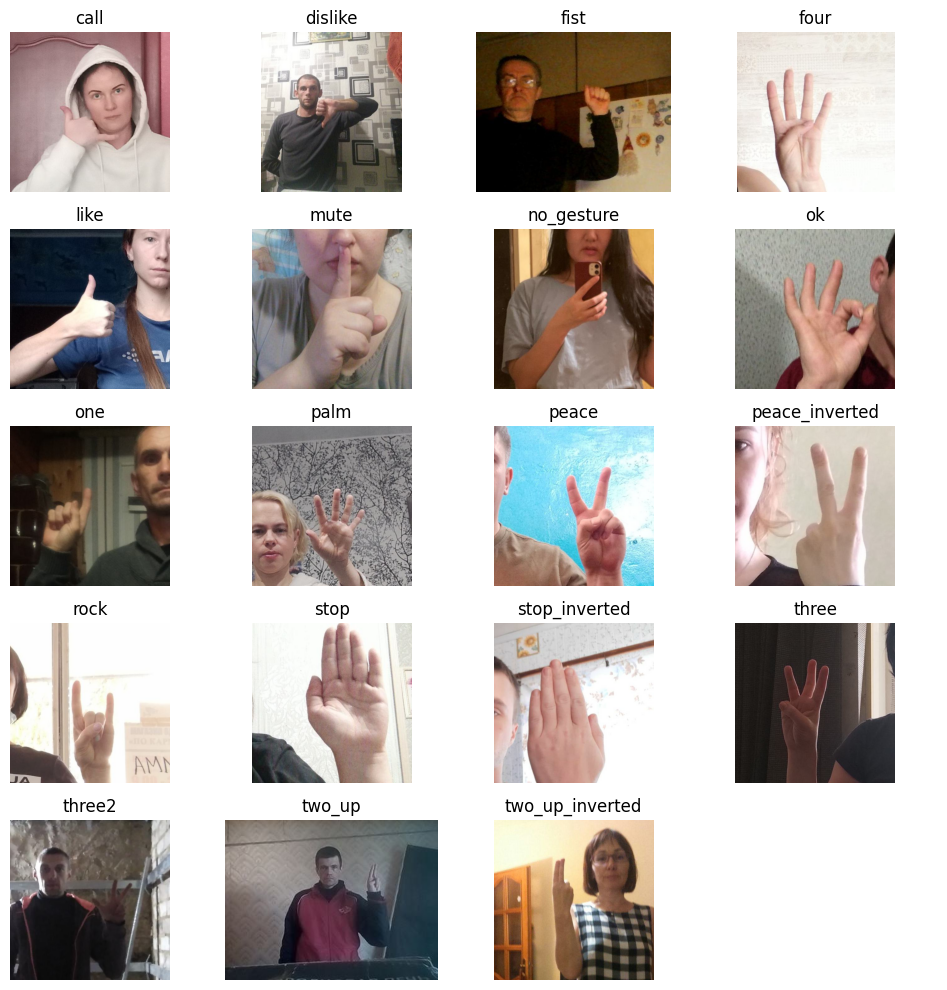

In [11]:
# Get paths for the first sample in the dataset for each class
sample_paths = [class_paths[0] for class_paths in class_folder_paths]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_paths) else 0)
n_cols = grid_size

# Create a list to store the first image found for each class
images = [Image.open(path) for path in sample_paths]
labels = [path.parent.name for path in sample_paths]
# labels = dataset[indices]['label']

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(images) and images[i]:
        # Add the image to the subplot
        ax.imshow(np.array(images[i]))
        # Set the title to the corresponding class name
        ax.set_title(labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [12]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

0
0                  resnet18.a1_in1k
1                  resnet18.a2_in1k
2                  resnet18.a3_in1k
3  resnet18.fb_ssl_yfcc100m_ft_in1k
4     resnet18.fb_swsl_ig1b_ft_in1k
5               resnet18.gluon_in1k
6                  resnet18.tv_in1k
7                resnet18d.ra2_in1k

### Inspecting the ResNet18-D Model Configuration

In [13]:
# Import the resnet module
from timm.models import resnet

# Define the ResNet model variant to use
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model
model_cfg = resnet.default_cfgs[resnet_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

0
url               https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
hf_hub_id                                                                                                               timm/
custom_load                                                                                                             False
input_size                                                                                                      (3, 224, 224)
test_input_size                                                                                                 (3, 288, 288)
fixed_input_size                                                                                                        False
interpolation                                                                                                         bicubic
crop_pct                                                                                                                0.875
test_crop_pct                                                                                                            0.95
crop_mode                                                                                                              center
mean                                                                                                    (0.485, 0.456, 0.406)
std                                                                                                     (0.229, 0.224, 0.225)
num_classes                                                                                                              1000
pool_size                                                                                                              (7, 7)
first_conv                                                                                                            conv1.0
classifier                                                                                                                 fc
origin_url                                                                https://github.com/huggingface/pytorch-image-models

### Retrieving Normalization Statistics

In [14]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Loading the ResNet18-D Model

In [15]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
resnet18 = resnet18.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
resnet18.device = device
resnet18.name = resnet_model

### Selecting the Model

In [16]:
model = resnet18

### Summarizing the Model

In [17]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

/home/innom-dt/mambaforge/envs/fastai-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs  \
0   ResNet       11.2 M                 11.2 M       44.9 M         2.7 G   
2   Conv2d          864                    864        3.5 K        14.2 M   
5   Conv2d        9.2 K                  9.2 K       36.9 K         150 M   
8   Conv2d       18.4 K                 18.4 K       73.7 K         301 M   
14  Conv2d       36.9 K                 36.9 K        147 K         150 M   
19  Conv2d       36.9 K                 36.9 K        147 K         150 M   
23  Conv2d       36.9 K                 36.9 K        147 K         150 M   
28  Conv2d       36.9 K                 36.9 K        147 K         150 M   
33  Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
38  Conv2d        147 K                  147 K        589 K         150 M   
43  Conv2d        8.2 K                  8.2 K       32.8 K         8.4 M   
46  Conv2d        147 K                  147 K        589 K         150 M   
51  Conv2d        147 K                  147 K        589 K         150 M   
56  Conv2d        294 K                  294 K        1.2 M        75.5 M   
61  Conv2d        589 K                  589 K        2.4 M         150 M   
66  Conv2d       32.8 K                 32.8 K        131 K         8.4 M   
69  Conv2d        589 K                  589 K        2.4 M         150 M   
74  Conv2d        589 K                  589 K        2.4 M         150 M   
79  Conv2d        1.2 M                  1.2 M        4.7 M        75.5 M   
84  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   
89  Conv2d        131 K                  131 K        524 K         8.4 M   
92  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   
97  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   

   Backward FLOPs            In size           Out size  
0           5.3 G   [1, 3, 256, 256]            [1, 19]  
2          14.2 M   [1, 3, 256, 256]  [1, 32, 128, 128]  
5           301 M  [1, 32, 128, 128]  [1, 32, 128, 128]  
8           603 M  [1, 32, 128, 128]  [1, 64, 128, 128]  
14          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
19          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
23          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
28          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
33          150 M    [1, 64, 64, 64]   [1, 128, 32, 32]  
38          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
43         16.8 M    [1, 64, 32, 32]   [1, 128, 32, 32]  
46          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
51          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
56          150 M   [1, 128, 32, 32]   [1, 256, 16, 16]  
61          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
66         16.8 M   [1, 128, 16, 16]   [1, 256, 16, 16]  
69          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
74          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
79          150 M   [1, 256, 16, 16]     [1, 512, 8, 8]  
84          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]  
89         16.8 M     [1, 256, 8, 8]     [1, 512, 8, 8]  
92          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]  
97          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]

## Preparing the Data

### Selecting a Sample Image

Image Label: dislike


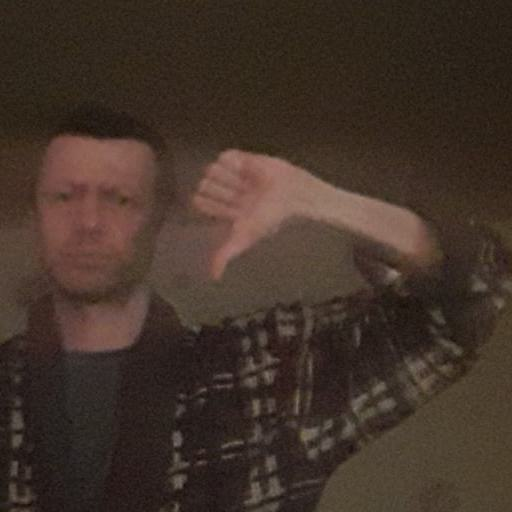

In [18]:
# Select a random item from the dataset
item_path = random.choice(img_paths)

label = item_path.parent.name
sample_img = Image.open(item_path)
    
print(f"Image Label: {label}")
    
# Display the image
sample_img

### Training-Validation Split

In [19]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(138361, 15374)

### Image Resizing and Padding

#### Set training image size

In [20]:
train_sz = (288,288)

#### Test the transform

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


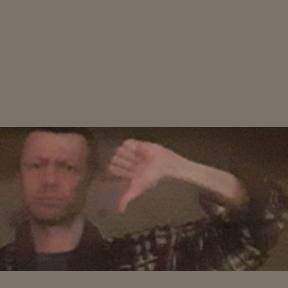

In [21]:
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=max(train_sz))

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

# Compose transforms to resize and pad input images
resize_pad = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([max(train_sz)] * 2, antialias=True)
])

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

### Image Transforms

In [22]:
%%writefile custom_functions.py
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from fastcore.transform import Transform

class ConditionalTypeTransform:
    def __init__(self, input_type, transforms_list):
        self.input_type = input_type
        self.transforms = transforms.Compose(transforms_list)

    def __call__(self, x):
        if isinstance(x, self.input_type):
            return self.transforms(x)
        else:
            return x

Overwriting custom_functions.py


In [23]:
from custom_functions import ConditionalTypeTransform

# Define the transformations for training and validation datasets
tfms = [
    resize_pad,
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*norm_stats),
]

item_tfms = [ConditionalTypeTransform(PILImage, tfms)]

### Training Batch Size

In [24]:
bs = 32

### Initialize DataLoaders

In [25]:
dls = ImageDataLoaders.from_folder(
    path=dataset_path,   # The path to the root folder containing the images.
    valid_pct=0.1,       # The percentage of the images that should be used for validation
    bs=bs,               # The number of samples to process in a single pass through the model
    item_tfms=item_tfms, # A list of transformations to apply to each individual image.
)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(dls.train)}')
print(f'Number of batches in validation DataLoader: {len(dls.valid)}')

/home/innom-dt/mambaforge/envs/fastai-env/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


Number of batches in train DataLoader: 4323
Number of batches in validation DataLoader: 481


## Fine-tuning the Model

### Set the Model Checkpoint Path

In [26]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

fastai-timm-image-classifier/2023-10-04_19-22-50/resnet18d.pth


### Save the Normalization Stats

In [27]:
# Convert tuples to dictionaries for easier JSON representation
norm_stats_dict = {"mean": norm_stats[0], "std_dev": norm_stats[1]}

# Export to JSON
with open(f"{checkpoint_dir}/norm_stats.json", "w") as f:
    json.dump(norm_stats_dict, f)

# Print the name of the file that the normalization stats were written to
print(f"{checkpoint_dir}/norm_stats.json")

fastai-timm-image-classifier/2023-10-04_19-22-50/norm_stats.json


### Saving the Class Labels

In [28]:
# Save class labels
class_labels = {"classes": list(dls.vocab)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

fastai-timm-image-classifier/2023-10-04_19-22-50/hagrid-classification-512p-no-gesture-150k-zip-classes.json


### Configure the Training Parameters

In [29]:
# Number of training epochs
epochs = 3

# Performance metrics
metrics = [error_rate, accuracy]

### Initialize the Fastai Learner

In [30]:
learn = Learner(dls, model, metrics=metrics, model_dir=checkpoint_dir.absolute())

### Find the Learning Rate

'Learning Rate: 0.0008262686314992607'

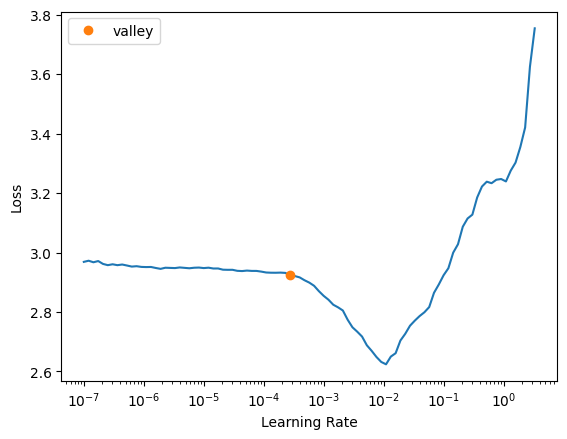

In [31]:
suggested_lrs = learn.lr_find()
lr = suggested_lrs.valley*3
f"Learning Rate: {lr}"

### Train the Model

In [32]:
learn.fine_tune(epochs, base_lr=lr, cbs=[MixedPrecision()])

### Save the Learner

In [33]:
learn.export(checkpoint_dir.absolute()/f"{model.name}.pkl")

### Save the Model Checkpont

In [34]:
torch.save(learn.model.state_dict(), checkpoint_path)

## Making Predictions with the Model

Target Class:        no_gesture
Predicted Class:     no_gesture
Confidence Score:        99.99%


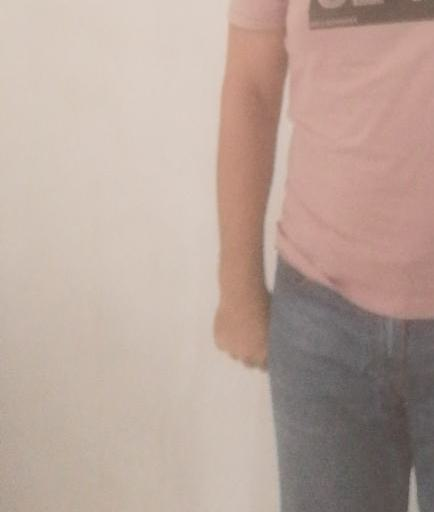

In [35]:
# Set the minimum input dimension for inference 
infer_sz = max(train_sz)

# Choose a random item from the dataset
item_path = random.choice(dls.valid_ds.items)

label = item_path.parent.name

# Open the image and resize it
sample_img = Image.open(item_path)
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = dls.vocab[torch.argmax(pred_scores)]

# Store the prediction data in a Pandas Series for easy formatting
pred_data = pd.Series({
    "Target Class:": label,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
})

# Print the prediction data
print(pred_data.to_string(header=False))

# Display the image
sample_img

### Testing the Model on New Data

Image already exists.


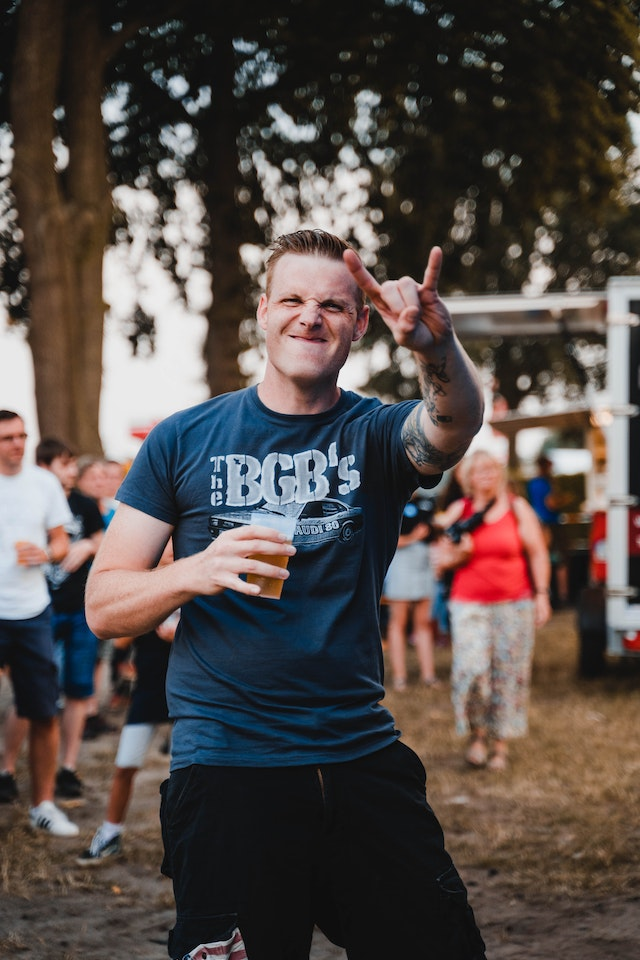

In [36]:
import urllib.request

test_img_url = "https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_path = Path("./pexels-man-doing-rock-and-roll-sign.jpg")

if test_img_path.is_file():
    print("Image already exists.")
else:
    urllib.request.urlretrieve(test_img_url, test_img_path)
    print("Image downloaded.")

sample_img = Image.open(test_img_path)
sample_img

Input Size:          (288, 416)
Target Class:              rock
Predicted Class:           rock
Confidence Score:        78.31%


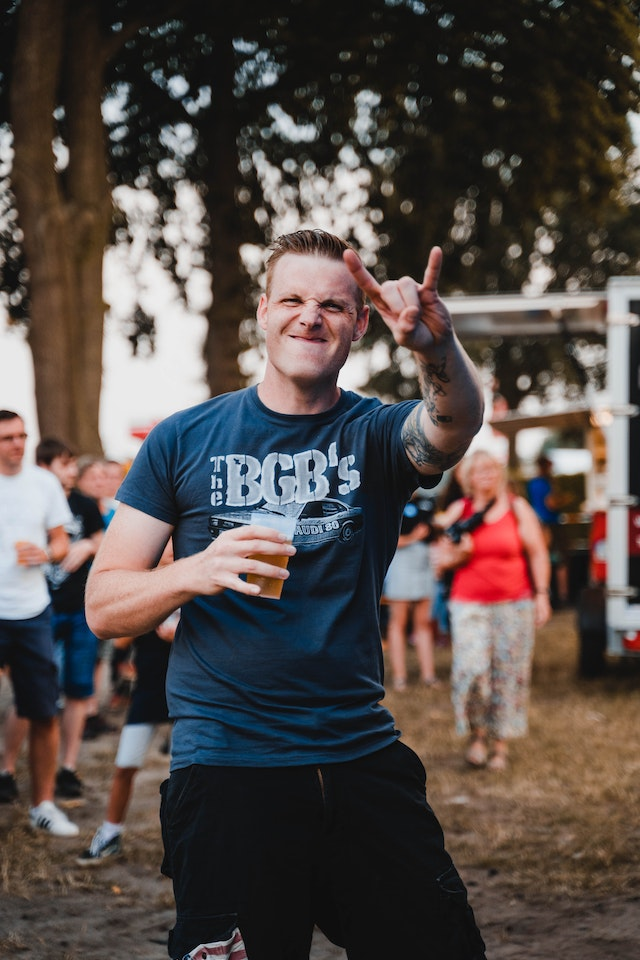

In [37]:
target_cls = "rock"

# Set the minimum input dimension for inference 
infer_sz = max(train_sz)

inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = dls.vocab[torch.argmax(pred_scores)]

# Store the prediction data in a Pandas Series for easy formatting
pred_data = pd.Series({
    "Input Size:": inp_img.size,
    "Target Class:": target_cls,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
})

# Print the prediction data
print(pred_data.to_string(header=False))

# Display the image
sample_img